In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from matplotlib.ticker import PercentFormatter
import numpy as np
import seaborn as sns
%matplotlib inline

# Understanding Crowdfunding Success

Crowdfunding is a great way to raise money for a project without taking out a loan. It has become very popular with the advent of the internet, which makes it really easy for people to show others what their idea is and why it is worthwhile. However, since a crowdfunding campaign can make or break a business idea or career it is worth the time to investigate whether there are any keys to succeeding. I have taken data from Kickstarter - the best known crowdfunding organization - to try and deduce any things one can do to increase the odds of success

### Business Questions
1. What is the biggest factor (if any) in the success of a Kickstarter project
2. What category of project would most likely succeed (Art, Photography, Tech etc.)
3. Are there any discernible differences between successful and failed projects?

### Data Understanding
The business questions above are some of the things that were set out in the beginning, but also came across during the course of data exploration. About 35% of Kickstarter projects succeed. Coming from a sample of almost 400,000 projects there is enough to go on to explore the reasons behind success.


### Gather Data
data found on: https://www.kaggle.com/kemical/kickstarter-projects

In [2]:
df_2016 = pd.read_csv('ks-projects-201612.csv', encoding="ISO-8859-1")
df_2018 = pd.read_csv('ks-projects-201801.csv', encoding="ISO-8859-1")

FileNotFoundError: [Errno 2] No such file or directory: 'ks-projects-201612.csv'

## Assess Data

### Investigating Differences
There are two datasets, but I am not sure what the difference between them is. My guess is that they contain a lot of the same data, but I want to take a look before discarding one of them.

In [5]:
df_2018.head(2)

ID                                           name        category  \
0  1000002330                The Songs of Adelaide & Abullah          Poetry   
1  1000003930  Greeting From Earth: ZGAC Arts Capsule For ET  Narrative Film   

  main_category currency    deadline     goal             launched  pledged  \
0    Publishing      GBP  2015-10-09   1000.0  2015-08-11 12:12:28      0.0   
1  Film & Video      USD  2017-11-01  30000.0  2017-09-02 04:43:57   2421.0   

    state  backers country  usd pledged  usd_pledged_real  usd_goal_real  
0  failed        0      GB          0.0               0.0        1533.95  
1  failed       15      US        100.0            2421.0       30000.00

In [6]:
df_2016.head(2)

ID                             name        category  main_category   \
0  1000002330  The Songs of Adelaide & Abullah          Poetry     Publishing   
1  1000004038                   Where is Hank?  Narrative Film   Film & Video   

  currency             deadline   goal             launched  pledged   state   \
0       GBP  2015-10-09 11:36:00   1000  2015-08-11 12:12:28        0  failed   
1       USD  2013-02-26 00:20:50  45000  2013-01-12 00:20:50      220  failed   

  backers  country  usd pledged  Unnamed: 13 Unnamed: 14 Unnamed: 15  \
0        0       GB            0         NaN         NaN         NaN   
1        3       US          220         NaN         NaN         NaN   

   Unnamed: 16  
0          NaN  
1          NaN

In [7]:
df_2018.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [8]:
df_2018['deadline'] = pd.to_datetime(df_2018['deadline'])

In [9]:
df_2018['deadline'].sort_values().head()

138572   2009-05-03
213711   2009-05-16
342226   2009-05-16
28960    2009-05-20
196244   2009-05-22
Name: deadline, dtype: datetime64[ns]

In [10]:
print(df_2018.shape)
print(df_2016.shape)

(378661, 15)
(323750, 17)


In [11]:
df_2016.columns = [s.replace(' ','') for s in df_2016.columns]

In [12]:
df_2016[df_2016['deadline']!= 'USD']['deadline'].sort_values().head()

269970               Esoteric
118552    2009-05-03 08:59:59
292628    2009-05-16 01:10:00
182855    2009-05-16 11:59:00
24856     2009-05-20 21:50:00
Name: deadline, dtype: object

#### Differences:
- the 2018 file is an extension of the 2016 file
    - 2018 file has about 55,000 more entries
- 2016 file has an extra two columns, but these are mostly null values so we would drop these features anyway

Conclusion is that we should just use the 2018 dataset for the analysis of Kickstarter Projects, just because it is essentially a more substantial dataset


## Cleaning Data

In [13]:
df = df_2018

In [14]:
#look at null values
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [77]:
df.category.value_counts()

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [78]:
df.main_category.value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [15]:
print(len(df.category.unique()))
print(len(df.main_category.unique())) 
#main_category will help us keep dimensionality low after one hot encoding

159
15


In [16]:
df.shape[0]==len(df.ID.unique()) #ID column is unique, but doesnt give us much info

True

looking at the features here I am thinking of dropping the following:
- `goal` as it is in local currency, and it would be easier to work with `usd_goal_real`
- `currency` as we will just use the information that is already converted to USD
- `usd pledged`: it has missing values, it is kickstarter information given about pledge amount in USD but this is already included in `usd_pledged_real`
- `pledged`: is funding raised in local currency, see explanation above
- `category`: `main_category` retains a lot of information, and will still increase our number of features quite significantly when one hot encoded. If we were to try to one hot encode `category` the dimensionality of our data would be very high.
- `ID`: all of the ID fields are unique, and it will not give us any information about project success.

In [18]:
#convert to common datetime format
df.launched = pd.to_datetime(df.launched)

In [20]:
#investigate data about countries
df.country.value_counts()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

In [21]:
#N,0" engineering to 'NO'
df.country = df.country.replace(to_replace='N,0"', value='NO')

Here I assume that in the `country` variable the value `N,0"` is an error, and am rewriting that as `NO`.

I will engineer a `success` variable from the information that is already in the dataset. I am defining `success` by a project raising at least as much as their goal had stipulated. This is also how Kickstarter defines success.

In [23]:
#engineer a 'success' variable
df['success'] = (df.usd_goal_real <= df.usd_pledged_real)*1

In [24]:
df.success.describe()

count    378661.000000
mean          0.361912
std           0.480554
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: success, dtype: float64

I will also engineer a `duration` feature to see if the timeline of a project influences the chances at success. The dataset contains information about the date and time a project was launched, and what the fundraising deadline was. From this it is straightforward to calculate how many hours the fundraising was supposed to last.

In [25]:
#engineer duration variable
df['duration'] = (df.deadline - df.launched).astype('timedelta64[h]')

I want to one hot encode the categorical variables: `main_category` and `coutnry`. This means that each state in each feature will be represented as a binary state. For example if a project originated in the U.S. that will be denoted as a value of `1` in the dataset, and all other countries will have a value of `0` for that project. This will make it easier for any models we deal by quantifying non-numerical values.

In [26]:
#one hot encode categorical variables, dropping unneeded variables
df_encoded = pd.get_dummies(df.drop(labels=['name', 'launched', 'deadline', 'state',
                                            'category', 'currency', 'usd pledged', 'pledged',
                                            'ID', 'goal'], axis=1), 
                            columns=['main_category', 'country'])

The average amount contributed to a project can give us some insight about whether we want to encourage many small contributions or a few larger ones.

In [27]:
#add a variable that shows average pledge for each project
df_encoded['average_backing'] = (df_encoded['usd_pledged_real']/(df_encoded['backers']+1))

## Data Analysis
I want to start off by understanding the data that underlies Kickstarter projects. This includes things like places of origin, predominant categories, durations, goals etc.

In [38]:
def percent_plot(data, title):
    '''
    INPUT: data- data of which to graph distribution
            title- graph title
    OUTPUT: Distribution of Data by Percentage Points
    '''
    ax = data.plot(kind='bar')
    plt.title(title)
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.show();

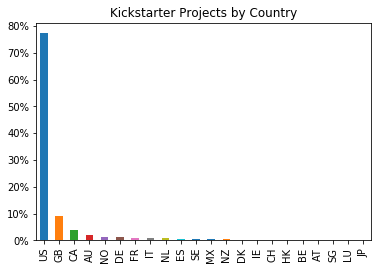

In [30]:
percent_plot((df.country.value_counts()/df.shape[0]*100), "Kickstarter Projects by Country")

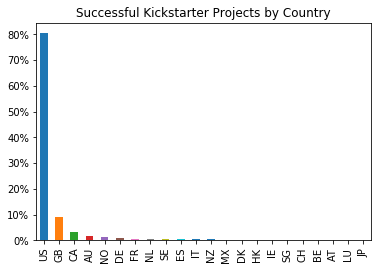

In [56]:
#successful projects by country`
percent_plot((df[df.usd_pledged_real>=df.usd_goal_real].country.value_counts()/
              df[df.usd_pledged_real>=df.usd_goal_real].shape[0]*100), 
             "Successful Kickstarter Projects by Country")

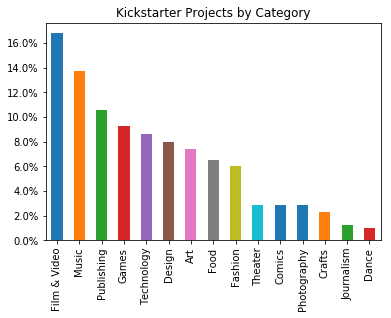

In [31]:
percent_plot((df.main_category.value_counts()/df.shape[0]*100), 
             "Kickstarter Projects by Category")

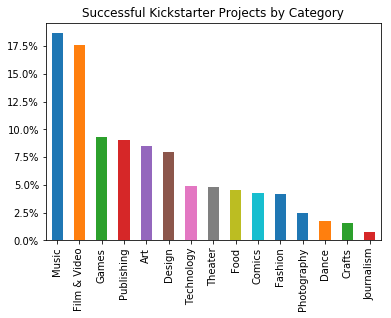

In [54]:
#categories of successful projects
percent_plot((df[df.usd_pledged_real>=df.usd_goal_real].main_category.value_counts()/
              df[df.usd_pledged_real>=df.usd_goal_real].shape[0]*100), 
             "Successful Kickstarter Projects by Category")

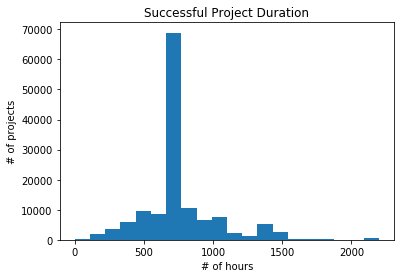

In [70]:
plt.hist(df_encoded[df_encoded.success==1].duration, bins=20)
plt.title('Successful Project Duration')
plt.xlabel('# of hours')
plt.ylabel('# of projects');

In [42]:
df_encoded[df_encoded.success==1].duration.describe()

count    137042.000000
mean        758.118548
std         282.562915
min           0.000000
25%         696.000000
50%         707.000000
75%         809.000000
max        2200.000000
Name: duration, dtype: float64

In [43]:
df_encoded[df_encoded.success==0].duration.describe()

count    241619.000000
mean        844.839739
std        1968.206205
min           0.000000
25%         699.000000
50%         714.000000
75%         949.000000
max      401735.000000
Name: duration, dtype: float64

In [58]:
df_encoded[df_encoded.success==1].usd_goal_real.describe()

count    1.370420e+05
mean     9.477405e+03
std      2.773888e+04
min      1.000000e-02
25%      1.323050e+03
50%      3.807055e+03
75%      1.000000e+04
max      2.015609e+06
Name: usd_goal_real, dtype: float64

In [59]:
df_encoded[df_encoded.success==0].usd_goal_real.describe()

count    2.416190e+05
mean     6.585991e+04
std      1.442797e+06
min      1.000000e-02
25%      2.690480e+03
50%      7.559720e+03
75%      2.200000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

In [61]:
df_encoded[df_encoded.success==1].average_backing.describe()

count    1.370420e+05
mean     1.667539e+02
std      7.484850e+03
min      3.950000e-01
25%      4.036037e+01
50%      6.254378e+01
75%      1.026918e+02
max      2.762572e+06
Name: average_backing, dtype: float64

In [62]:
df_encoded[df_encoded.success==0].average_backing.describe()

count    241619.000000
mean         43.500706
std         125.853411
min           0.000000
25%           0.535833
50%          19.575000
75%          49.021940
max       17425.000000
Name: average_backing, dtype: float64

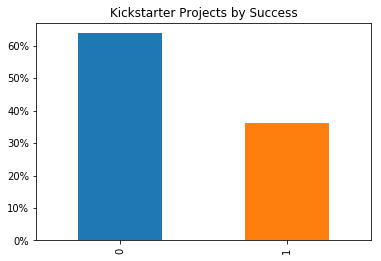

In [32]:
percent_plot((df_encoded.success.value_counts()/df.shape[0]*100),
             "Kickstarter Projects by Success")

#### Descriptive Statistics
What can we learn from looking at some descriptive statistics?
What is correlated with success? We have to keep in mind that correlation does not imply causality, but this could give us a good idea anyway.

In [34]:
def corr_plot(features, fig_size):
    '''
    INPUT: features- which columns of df_encoded to calculate correlation
            fig_size- size of the correlation heatmap for ease of reading
    OUTPUT: Seaborn Heatmap of Correlations
    '''
    corr=df_encoded[features].corr()
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            ax=ax, linewidths=0.01);

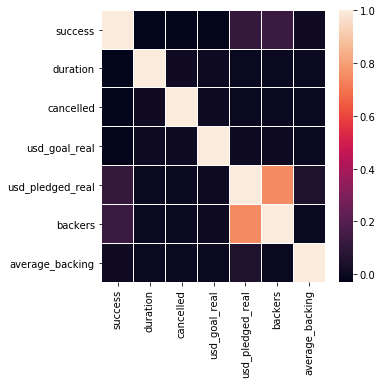

In [35]:
#correlation between the time, and goal and pldeged money
corr_plot(['success','duration', 'cancelled', 'usd_goal_real', 
                        'usd_pledged_real', 'backers', 'average_backing'], (5,5))

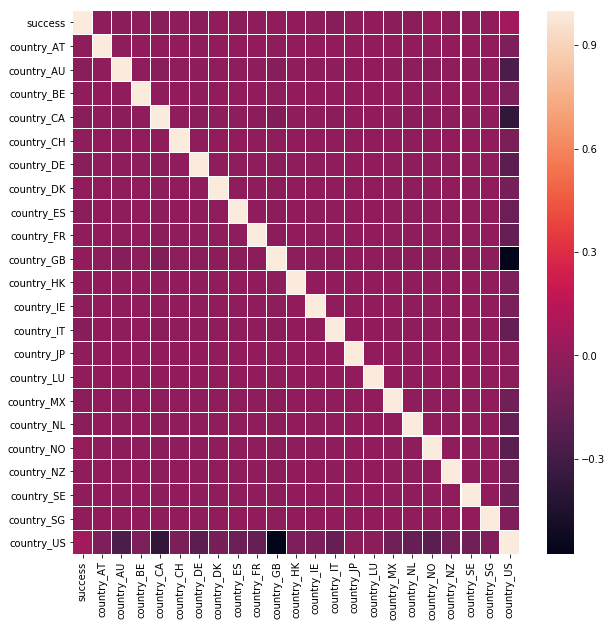

In [36]:
#correlation between success and country of origin for project
corr_plot(['success', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US'], (10,10))

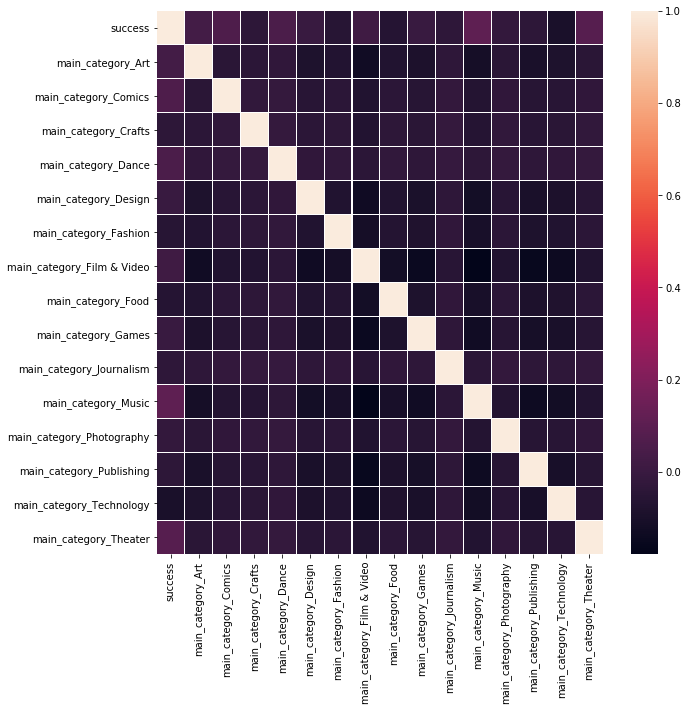

In [37]:
#correlation between sphere of project and success
corr_plot(['success','main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'], (10,10))

In [53]:
#number of dollars pledged per hour
(df_encoded.usd_pledged_real/(df_encoded.duration+1)).describe()

count    378661.000000
mean         11.976360
std         116.407377
min           0.000000
25%           0.040531
50%           0.842644
75%           5.575035
max       27010.605936
dtype: float64

### ML Classification Model
Let's see if we can accurately predict which projects will be successful and which ones won't.
We will use a random forest classifier as this ensemble learner is usually quite powerful, and is not distance based (so we dont have to further scale the features like `duration` or `usd_pledged_real` or `usd_goal_real`)

In [76]:
def RFC_model(randomState, X_train, X_test, y_train, y_test):
    '''
    INPUT:
            randomState - the random state parameter for random forest classifier
            X_train - training set split for the independent variables
            X_test - testing set split for independent variables
            y_train - training set split for the dependent variables
            y_test - testing set split for the dependent variables
    OUTPUT: prints accuracy of the random forest classifier
    '''
    rand_forest = RandomForestClassifier()
    rand_forest.fit(X_train, y_train)
    forest_test_predictions = rand_forest.predict(X_test)
    print(accuracy_score(y_test, forest_test_predictions))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(['success'], axis='columns').values,
                                                    df_encoded.success, 
                                                    test_size=0.2)

In [81]:
RFC_model(42, X_train, X_test, y_train, y_test)

0.9938732124701253


In [95]:
#importance of features rounded to nearest 3 decimals
rand_forest.feature_importances_.round(3)

array([0.285, 0.403, 0.251, 0.   , 0.027, 0.001, 0.001, 0.   , 0.   ,
       0.003, 0.001, 0.001, 0.001, 0.003, 0.   , 0.006, 0.   , 0.001,
       0.003, 0.002, 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.002, 0.   , 0.   , 0.   , 0.001])

This model does pretty well, however we have included the `usd_pledged_real` and `backers` features in this which might be skewing the results. Remember that `usd_pledged_real` and `backers` were very highly correlated with `success` (obviously).

Lets remove this variable and see how the model does.

In [107]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').values, 
    df_encoded.success, test_size=0.2, random_state=0)
RFC_model(42, X_train_2, X_test_2, y_train_2, y_test_2)

0.6466929872050493


In [103]:
#importance of features rounded to nearest 3 decimals
rand_forest_2.feature_importances_.round(3)

array([0.429, 0.002, 0.473, 0.002, 0.005, 0.003, 0.004, 0.002, 0.005,
       0.003, 0.004, 0.003, 0.002, 0.012, 0.002, 0.003, 0.01 , 0.008,
       0.001, 0.002, 0.001, 0.002, 0.001, 0.002, 0.001, 0.001, 0.001,
       0.003, 0.001, 0.001, 0.002, 0.   , 0.   , 0.001, 0.001, 0.002,
       0.001, 0.001, 0.001, 0.004])

In [73]:
def print_important_features(features, df):
    '''
    INPUT: 
        features- the column number of feature you want to print
        df - the df you want to do this operation on
    OUTPU: prints the name of each feature that you have chosen
    '''
    for col in features:
        print(df.columns[col])

In [74]:
print_important_features([0,2,13], df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns'))

usd_goal_real
duration
main_category_Music


In [125]:
#grid search to optimize random forest classifier
parameters={'n_estimators':[5,10,15,20],
            'max_depth':[None,2,5,10,15],
            'min_samples_split':[2, 4, 8]}
clf = RandomForestClassifier(random_state=42)
scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train_2, y_train_2)
best_clf = grid_fit.best_estimator_

In [118]:
predictions = best_clf.predict(X_test_2)

In [124]:
print(accuracy_score(y_test_2, predictions))

0.681380639879577


In [126]:
best_clf.feature_importances_.round(3)

array([0.412, 0.007, 0.266, 0.002, 0.024, 0.012, 0.015, 0.006, 0.027,
       0.004, 0.017, 0.004, 0.006, 0.053, 0.005, 0.014, 0.04 , 0.039,
       0.   , 0.002, 0.001, 0.003, 0.001, 0.003, 0.001, 0.001, 0.001,
       0.004, 0.001, 0.001, 0.004, 0.   , 0.   , 0.002, 0.002, 0.004,
       0.001, 0.001, 0.   , 0.015])

In [72]:
#which features were most important in model
print_important_features([0,2,4,8,13,17], df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns'))

usd_goal_real
duration
main_category_Comics
main_category_Fashion
main_category_Music
main_category_Theater


### Conclusion

Based on the optimized Random Forest Classifier, for which we removed the `usd_pledged_real` and `backers` features as these were going to distort our model as we want to know what can help us get more backers and funding.

Based on the feature importance of the Random Forest Ensemble Learner, the most important features are `usd_goal_real`, `duration`, `main_category_Comics`, `main_category_Fashion`, `main_category_Music`, and `main_category_Theater`. This shows us that what we set as the monetary goal and how long we allow people to pledge for really does matter a lot. What is quite surprising for me, and is corroborated by the analysis of descriptive statistics is that Arts and Performance are more likely to succeed. I wonder why...

Overall I would not say there is one contributing factor to success on Kickstarter. Many things contribute to it that cannot be explained through data. For example, the business idea, planning, incentives to pledge, or project design cannot be easily quantified. Maybe if we had sentiment data from the comments on each project we could combine that into a much larger and better classification model to predict our success.

##### Blog Post
Read the blog post about this work here: https://medium.com/@mati.kucz95/crowdfunding-success-chance-or-strategy-4cedf9e1266f